In [5]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

#load data
import data_import as data
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Model for training
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ( 
    Conv2D, BatchNormalization, Dropout, MaxPool2D, MaxPooling2D,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add
)

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Data Load 
### scaling, preprocessing

In [6]:
# load dataset
train = pd.read_csv(os.getcwd()+'/data/train.csv')
test  = pd.read_csv(os.getcwd()+'/data/test.csv')
submission = pd.read_csv(os.getcwd()+'/data/submission.csv')

In [7]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [10]:
#케라스가 내 모델에 맞추기 위해 사용할 수 있는 one-hot 벡터 배열로 바꾸기
#입력이미지의 shape 이 (batch_size, width, height, n_channels)로 넣어줘야함
from keras.utils.np_utils import to_categorical
x_data = (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 28, 28, 1)

#레이블 준비하기
y_data = to_categorical(train['digit'].values)
print(y_data.shape)
y_data

(2048, 10)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Data Split & Data Augmentation

In [39]:
# 아마 성능 향상의 가장 큰 요인, 데이터 증강
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1)
print(x_train.shape)
print(x_val.shape)
print(y_data.shape)

NameError: name 'train_test_split' is not defined

# CNN 모델 생성

In [41]:
model = Sequential() #클래스 객체 생성
model.add(Conv2D(32, kernel_size = 3, input_shape = (28, 28, 1)))  #26 * 26 * 32
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, kernel_size = 3)) # 24 * 24 * 32
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu')) #12 * 12 * 32
model.add(Dropout(0.4)) 

model.add(Conv2D(64, kernel_size = 3))# 10 * 10 * 64
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size = 3)) # 8 * 8 * 64
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu')) # 4 * 4 * 64
model.add(Dropout(0.4)) 

model.add(Conv2D(128, kernel_size = 4)) # 1 * 1 * 128
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 10, 64)       

In [42]:
# COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
# 모델 학습시키기 이전에, compile 메소드를 통해서 학습방식에 대한 환경 설정
# 정규화기(optimizer)
# 손실함수(loss function)
# 기준 리스트 (metrics) -> 분류 문제에서는 metrics = ['accuracy'] 로 설정
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
from tensorflow.keras.callbacks import LearningRateScheduler
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

## without datagen

In [24]:
epochs = 45
#fit 메서드로 트레이닝 시작
hist = model.fit(
    x_train, y_train, batch_size = 32,
    epochs=epochs, 
    steps_per_epoch=x_train.shape[0]//32,
    validation_data=(x_val, y_val), 
    callbacks=[annealer],
    verbose=1
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(hist.history['acc']):.5f}, " +
    f"Validation accuracy={max(hist.history['val_acc']):.5f}"
)

Epoch 1/45
57/57 [==============================] - 184s 3s/step - loss: 1.5657 - acc: 0.4403 - val_loss: 1.1813 - val_acc: 0.5805
Epoch 2/45
57/57 [==============================] - 190s 3s/step - loss: 0.5734 - acc: 0.7969 - val_loss: 0.9082 - val_acc: 0.7659
Epoch 3/45
57/57 [==============================] - 193s 3s/step - loss: 0.2097 - acc: 0.9250 - val_loss: 0.9827 - val_acc: 0.7756
Epoch 4/45
57/57 [==============================] - 189s 3s/step - loss: 0.1056 - acc: 0.9626 - val_loss: 0.9718 - val_acc: 0.8146
Epoch 5/45
57/57 [==============================] - 189s 3s/step - loss: 0.0675 - acc: 0.9774 - val_loss: 1.0411 - val_acc: 0.8146
Epoch 6/45
57/57 [==============================] - 190s 3s/step - loss: 0.0488 - acc: 0.9832 - val_loss: 1.1070 - val_acc: 0.7951
Epoch 7/45
57/57 [==============================] - 191s 3s/step - loss: 0.0375 - acc: 0.9873 - val_loss: 1.0910 - val_acc: 0.8146
Epoch 8/45
57/57 [==============================] - 197s 3s/step - loss: 0.0298 - a

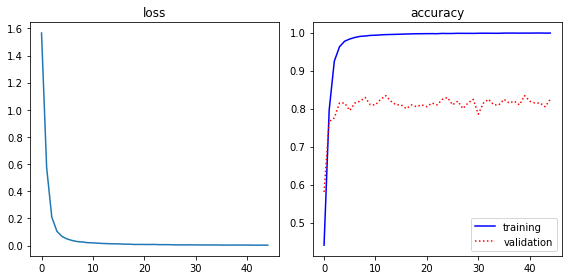

In [25]:
#성능 visualize
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("accuracy")
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="validation")
plt.legend()
plt.tight_layout()
plt.show()

## with datagen

In [26]:
epochs = 45
#fit 메서드로 트레이닝 시작
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=epochs, 
    steps_per_epoch=x_train.shape[0]//32,
    validation_data=(x_val, y_val), 
    callbacks=[annealer], 
    verbose=0
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(hist.history['acc']):.5f}, " +                                   
    f"Validation accuracy={max(hist.history['val_acc']):.5f}"
)

CNN: Epochs=45, Train accuracy=0.77526, Validation accuracy=0.81463


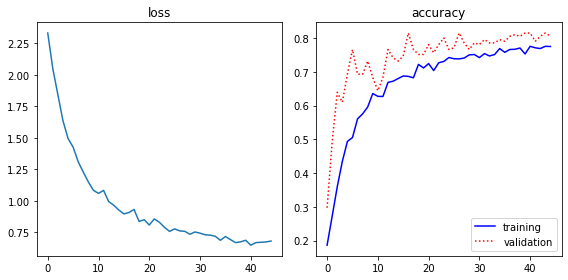

In [27]:
#성능 visualize
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("accuracy")
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="validation")
plt.legend()
plt.tight_layout()
plt.show()

# 배치 사이즈 수정 (기존 32) 64 수정

In [1]:
# epochs = 45
# #fit 메서드로 트레이닝 시작
# hist = model.fit_generator(
#     datagen.flow(x_train, y_train, batch_size=64),
#     epochs=epochs, 
#     steps_per_epoch=x_train.shape[0]//64,
#     validation_data=(x_val, y_val), 
#     callbacks=[annealer], 
#     verbose=0
# )

# print(
#     f"CNN: Epochs={epochs:d}, " +
#     f"Train accuracy={max(hist.history['acc']):.5f}, " +                                   
#     f"Validation accuracy={max(hist.history['val_acc']):.5f}"
# )

In [33]:
epochs = 45
#fit 메서드로 트레이닝 시작
hist = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=epochs, 
    steps_per_epoch=x_train.shape[0]//128,
    validation_data=(x_val, y_val), 
    callbacks=[annealer], 
    verbose=0
)

print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(hist.history['acc']):.5f}, " +                                   
    f"Validation accuracy={max(hist.history['val_acc']):.5f}"
)

CNN: Epochs=45, Train accuracy=0.86006, Validation accuracy=0.85366


In [2]:
# epochs = 45
# #fit 메서드로 트레이닝 시작
# hist = model.fit_generator(
#     datagen.flow(x_train, y_train, batch_size=256),
#     epochs=epochs, 
#     steps_per_epoch=x_train.shape[0]//256,
#     validation_data=(x_val, y_val), 
#     callbacks=[annealer], 
#     verbose=0
# )

# print(
#     f"CNN: Epochs={epochs:d}, " +
#     f"Train accuracy={max(hist.history['acc']):.5f}, " +                                   
#     f"Validation accuracy={max(hist.history['val_acc']):.5f}"
# )

# LeNet5 모델 생성

In [56]:
class LeNet5(Model):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = Conv2D(6, kernel_size=(5,5), padding='same', activation='relu')
        self.conv2 = Conv2D(16, kernel_size=(5,5), activation='relu')
        self.max_pool = MaxPooling2D(pool_size=(2,2))
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')
        self.dense3 = Dense(num_classes, activation='softmax')
    def call(self, x):
        x = self.max_pool(self.conv1(x))
        x = self.max_pool(self.conv2(x))
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x)))
        return x

# ResNet 모델 생성

In [57]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
               nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
               nn.BatchNorm2d(self.expansion*planes))

In [58]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
    
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

In [59]:
#adam = Adam(lr=5e-4)
# COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
# https://crazyj.tistory.com/153
model = LeNet5(num_classes)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [62]:
_ = model.predict(x_val[:10])
model.summary()

Model: "le_net5_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  156       
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  48120     
_________________________________________________________________
dense_4 (Dense)              multiple                  10164     
_________________________________________________________________
dense_5 (Dense)              multiple                  85

In [61]:
# Set a learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [63]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1, write_graph=True),
]

In [ ]:
from sklearn.model_selection import train_test_split
epochs = 45
# Train-Test를 9:1로 분리
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train, y_train, test_size = 0.1)

#fit 메서드로 트레이닝 시작
hist = model.fit(
    X_train2, y_train2, batch_size = 20,
    epochs=epochs, 
    
    #steps_per_epoch=X_train2.shape[0]//20,
    validation_data=(X_val2, y_val2), 
    callbacks=[annealer],
    verbose=1
)
print(
    f"CNN: Epochs={epochs:d}, " +
    f"Train accuracy={max(hist.history['acc']):.5f}, " +
    f"Validation accuracy={max(hist.history['val_acc']):.5f}"
)

In [64]:
history = model.fit(x_train, y_train, batch_size=32, epochs=80,
          validation_data=(x_val, y_val), verbose=1, callbacks = callbacks)

Train on 1638 samples, validate on 410 samples
Epoch 1/80
1638/1638 [==============================] - 2s 1ms/sample - loss: 2.2506 - acc: 0.1673 - val_loss: 2.1464 - val_acc: 0.1805
Epoch 2/80
1638/1638 [==============================] - 1s 850us/sample - loss: 2.0218 - acc: 0.2558 - val_loss: 1.9652 - val_acc: 0.2829
Epoch 3/80
1638/1638 [==============================] - 1s 735us/sample - loss: 1.8397 - acc: 0.3443 - val_loss: 1.8030 - val_acc: 0.3537
Epoch 4/80
1638/1638 [==============================] - 1s 800us/sample - loss: 1.6670 - acc: 0.4176 - val_loss: 1.7079 - val_acc: 0.3878
Epoch 5/80
1638/1638 [==============================] - 1s 762us/sample - loss: 1.5201 - acc: 0.4707 - val_loss: 1.6458 - val_acc: 0.4122
Epoch 6/80
1638/1638 [==============================] - 1s 760us/sample - loss: 1.4171 - acc: 0.4988 - val_loss: 1.5197 - val_acc: 0.4634
Epoch 7/80
1638/1638 [==============================] - 1s 819us/sample - loss: 1.3033 - acc: 0.5464 - val_loss: 1.4999 - val_a

# ResNet with Transfer Learning

In [79]:
#from torchvision import datasets, transforms
#model_resnet=models.resnet50(pretrained=True)

In [91]:
print(x_train.shape)

(1638, 28, 28, 1)


In [77]:
#change the first layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs,10)

In [83]:
model = models.resnet18(pretrained =False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [84]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [92]:
def train(model, train_loader,target optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        #data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data[batch_idx])
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), 
                loss.item()))

In [87]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy